# Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

Turkish:
https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d



In [1]:
# This part probably will be enough for utilizing Drive in Colab
# but examine links above if you encounter with problems.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Now, you will work on Architectural Heritage Elements Dataset and classify these elements into 10 categories

After having mounted the Jupyter Notebook to Google Drive, navigate the following address: https://drive.google.com/drive/folders/1PLXZYjGeaM1rekMKUTo8mlaaPeFOrBft?usp=sharing


Add this folder entirely to your Google Drive. If you have done it correctly, then you should be able to see *data* folder in your drive.

You can examine the dataset in the following address: https://old.datahub.io/dataset/architectural-heritage-elements-image-dataset


### Don't forget to choose the right runtime from the menu above. (GPU should be selected)

In [2]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Sat Dec 26 13:14:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### You are free to utilize Pytorch methods in this part of the homework. You will be using pretained models ResNet-50, DenseNet-121 and your own model.

In [3]:
# All libraries are already presented in Colab Servers, we don't need to install anything with pip
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Pre-trained Models

You can find tutorials on how to load those models at pytorch.org . Don't forget to use pretrained=True if you wish to do finetuning.

In [4]:
# Reproducible results
torch.manual_seed(2020)
# Load ResNet-50 and DenseNet-121 model seperately here
resnet50 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
densenet121 = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
# Transfer learning applied below (weights of the models are not updated during training
# except their classifiers)
# Classifiers of both models are replaced with a FC layer with 10 layers at the output
for param in resnet50.parameters():
    param.requires_grad = False
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)
for param in densenet121.parameters():
    param.requires_grad = False
densenet121.classifier = nn.Linear(densenet121.classifier.in_features, 10)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


## Your Model

Additionally, build your own model which is different from the other models, train on the Architectural Heritage Elements dataset.

My model defined below can be represented with the following LeNet style NN architectural drawing. It's a very shallow and simple feature extractor.

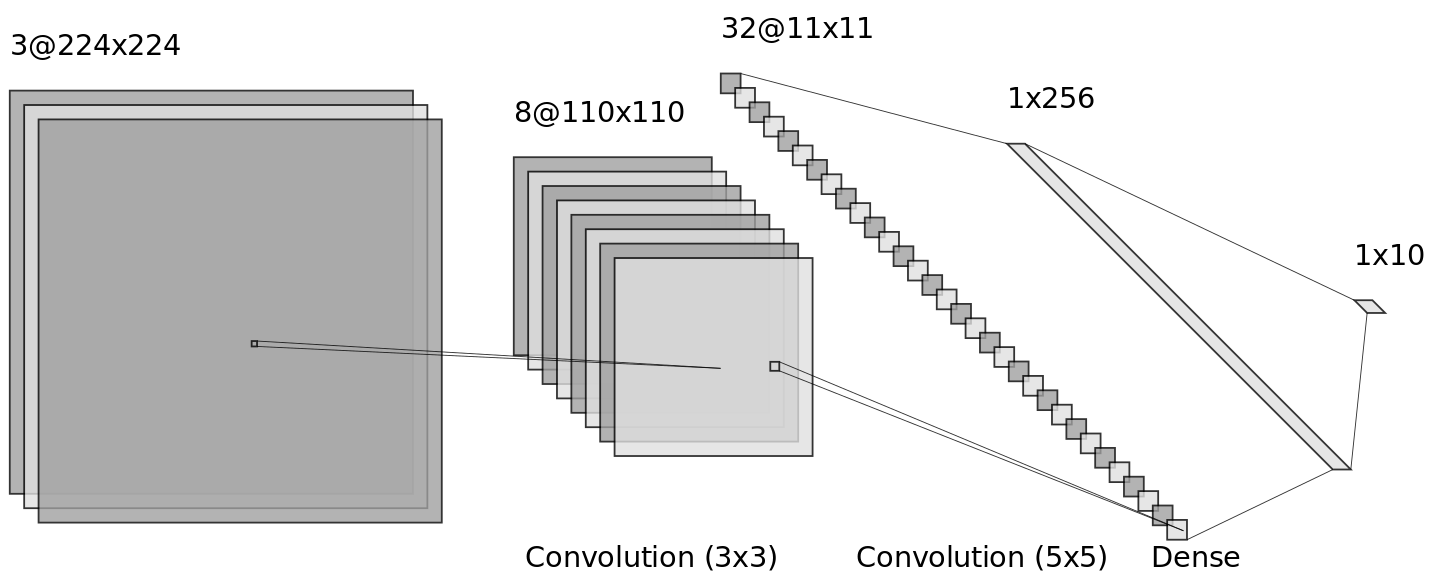

In [5]:
import torch.nn.functional as F


class YourModel(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        super(YourModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, dilation=3, padding=1, padding_mode="reflect")
        self.conv2 = nn.Conv2d(8, 32, 5, stride=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        # TO DO: Your neural network design
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
###  Here are some training parameters which you can tweak
batch_size = 64
learning_rate = 1e-3
regularization_rate = 1e-5
n_epochs = 20
use_gpu = True
test_every = 1
momentum = 0.9
###

# You may want to tweak them too and you can use different parameter settings for different models. 
# These are just examples
model = YourModel()
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
criteria = nn.CrossEntropyLoss()

## DataLoader

Here we provide you the codes for loading the train data, validation data and test data. Please ensure that you understood how PyTorch methods like ImageFolder, DataLoader and transformations work.

In [7]:
train_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
val_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
test_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

abs_path = "/content/drive/MyDrive/ITU - Computer Engineering/BLG561E/HW2"
train_path = os.path.join(abs_path, 'data/train')
val_path = os.path.join(abs_path, 'data/val')
test_path = os.path.join(abs_path, 'data/test')
train_dataset = ImageFolder(train_path, train_transforms)
val_dataset = ImageFolder(val_path, val_transforms)
test_dataset = ImageFolder(test_path, test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=4, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=4, shuffle=False)

# Train your own model

Don't forget to include appropriate regularizations. Choose appropriate set of hyperparameters such as Learning Rate etc. You may insert new cells.

In [8]:
# It modifies the behaviour of modules like BatchNorm and Dropout for training purposes
# Use your own model
model.train()
if use_gpu:
    model.cuda()
    criteria.cuda()

# Some example diagnostics.

# Loss for every iteration
losses_iter_train = []
# Loss for epoch (averaging the iteration-wise loss)
losses_epoch_train = []
accuracy_iter_train = []
accuracy_epoch_train = []

losses_iter_val = []
losses_epoch_val = []
accuracy_iter_val = []
accuracy_epoch_val = []
running_loss = 0

# Write the training loop
for epoch in range(n_epochs):
    for ix, data in enumerate(train_loader):
        optimizer.zero_grad()
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        output = model(img)
        loss = criteria(output, label)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        losses_iter_train.append(loss.item())
        if ix % 40 == 39:    # print every 80 mini-batches
            print('Train [%d, %5d] running loss: %.5f' % (epoch + 1, ix + 1, running_loss/40))
            running_loss = 0
    running_loss = 0
    losses_epoch_train.append(np.mean(losses_iter_train[epoch*len(train_loader):(epoch+1)*len(train_loader)]))
    print('Train [Epoch %d] loss: %.5f' % (epoch + 1, losses_epoch_train[epoch]))

    if epoch % test_every == 0:
        with torch.no_grad():
            model.eval()
            val_ix = epoch // test_every
            total_true = 0
            total_false = 0
            for ix, data in enumerate(val_loader):
                img, label = data
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()
                output = model(img)
                loss = criteria(output, label)
                _, prediction = torch.max(output.data, 1)
                total_true += torch.sum(prediction == label)
                total_false += torch.sum(prediction != label)
                # Statistics
                running_loss += loss.item()
                losses_iter_val.append(loss.item())
                # pdb.set_trace()
                if ix % 40 == 39:    # print every 40 mini-batches
                    print('Val [%d, %5d] running loss: %.5f' % (epoch + 1, ix + 1, running_loss/40))
                    running_loss = 0
            running_loss = 0
            losses_epoch_val.append(np.mean(losses_iter_val[val_ix*len(val_loader):(val_ix+1)*len(val_loader)]))
            print('Val [Epoch %d] loss: %.5f' % (epoch + 1, losses_epoch_val[val_ix]))
            print('Val Acc: {:.4}%'.format(100 * total_true / (total_true + total_false)))
        model.train()

Train [1,    40] running loss: 2.28606
Train [1,    80] running loss: 2.21847
Train [1,   120] running loss: 2.12484
Train [Epoch 1] loss: 2.18976
Val [1,    40] running loss: 2.03971
Val [Epoch 1] loss: 2.05901
Val Acc: 27.14%
Train [2,    40] running loss: 1.99343
Train [2,    80] running loss: 1.90980
Train [2,   120] running loss: 1.79983
Train [Epoch 2] loss: 1.87863
Val [2,    40] running loss: 1.78018
Val [Epoch 2] loss: 1.80618
Val Acc: 36.36%
Train [3,    40] running loss: 1.69490
Train [3,    80] running loss: 1.66813
Train [3,   120] running loss: 1.59039
Train [Epoch 3] loss: 1.64036
Val [3,    40] running loss: 1.65215
Val [Epoch 3] loss: 1.65390
Val Acc: 42.4%
Train [4,    40] running loss: 1.56507
Train [4,    80] running loss: 1.51819
Train [4,   120] running loss: 1.50598
Train [Epoch 4] loss: 1.52428
Val [4,    40] running loss: 1.59748
Val [Epoch 4] loss: 1.59686
Val Acc: 45.06%
Train [5,    40] running loss: 1.49198
Train [5,    80] running loss: 1.42409
Train [5,  

## Test your model

Measure the performance against test set. Complete the code below.

In [9]:
# It modifies the behaviour of modules like BatchNorm and Dropout for test purposes
# Dropout no longer works when .eval() is called.
# BatchNorm uses the learned parameters

model.eval()

with torch.no_grad():
    total_true = 0
    total_false = 0
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        output = model(img)
        _, prediction = torch.max(output.data, 1)
        total_true += torch.sum(prediction == label)
        total_false += torch.sum(prediction != label)
        # Statistics
        # pdb.set_trace()
    print('Test Acc: {:.2f}%'.format(100 * total_true / (total_true + total_false)))

Test Acc: 58.55%


# Plot your model

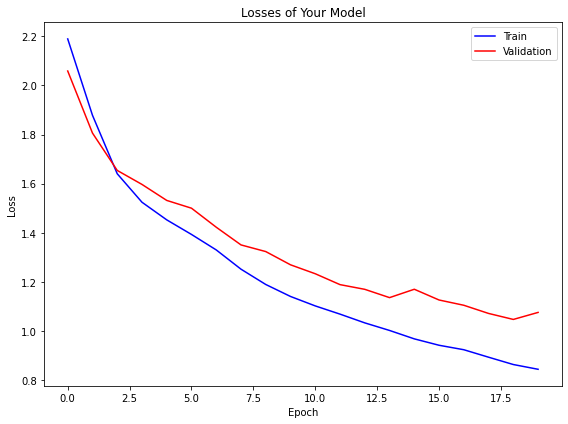

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(losses_epoch_train, c="b", label="Train")
axes.plot(losses_epoch_val, c="r", label="Validation")
axes.set_title("Losses of Your Model")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.legend(loc="best")
fig.tight_layout()

My model has achieved pretty respectable validation and test accuracies considering how shallow the DNN is. Even though it is not very noticable at the first glance, the model suffers from overfitting the training data. The momentum of the curves show us that as the number of epochs increase, we will start to see the gap between the validation and the training loss curves get wider.

# Train, Test and Plot Methods

These methods are defined below in order to reduce code duplication in the upcoming cells.

In [11]:
def train_model(train_loader, val_loader, model, optimizer, criterion, n_epochs=20, test_every=1, print_every=40):
    model.train()
    if use_gpu:
        model.cuda()
        criteria.cuda()

    losses_iter_train = []
    losses_epoch_train = []

    losses_iter_val = []
    losses_epoch_val = []
    running_loss = 0

    # Write the training loop
    for epoch in range(n_epochs):
        for ix, data in enumerate(train_loader):
            optimizer.zero_grad()
            img, label = data
            if use_gpu:
                img = img.cuda()
                label = label.cuda()
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            losses_iter_train.append(loss.item())
            if ix % print_every == print_every - 1:    # print every print_every iteration
                print('Train [%d, %5d] running loss: %.5f' % (epoch + 1, ix + 1, running_loss/print_every))
                running_loss = 0
        running_loss = 0
        losses_epoch_train.append(np.mean(losses_iter_train[epoch*len(train_loader):(epoch+1)*len(train_loader)]))
        print('Train [Epoch %d] loss: %.5f' % (epoch + 1, losses_epoch_train[epoch]))

        if epoch % test_every == 0:
            with torch.no_grad():
                model.eval()
                val_ix = epoch // test_every
                total_true = 0
                total_false = 0
                for ix, data in enumerate(val_loader):
                    img, label = data
                    if use_gpu:
                        img = img.cuda()
                        label = label.cuda()
                    output = model(img)
                    loss = criterion(output, label)
                    _, prediction = torch.max(output.data, 1)
                    total_true += torch.sum(prediction == label)
                    total_false += torch.sum(prediction != label)
                    # Statistics
                    running_loss += loss.item()
                    losses_iter_val.append(loss.item())
                    if ix % print_every == print_every - 1:
                        print('Val [%d, %5d] running loss: %.5f' % (epoch + 1, ix + 1, running_loss/print_every))
                        running_loss = 0
                running_loss = 0
                losses_epoch_val.append(np.mean(losses_iter_val[val_ix*len(val_loader):(val_ix+1)*len(val_loader)]))
                print('Val [Epoch %d] loss: %.5f' % (epoch + 1, losses_epoch_val[val_ix]))
                print('Acc: {:.4}%'.format(100 * total_true / (total_true + total_false)))
            model.train()

    return losses_iter_train, losses_epoch_train, losses_iter_val, losses_epoch_val

In [12]:
def test_model(test_loader, model):
    model.eval()

    with torch.no_grad():
        total_true = 0
        total_false = 0
        for data in test_loader:
            img, label = data
            if use_gpu:
                img = img.cuda()
                label = label.cuda()
            output = model(img)
            _, prediction = torch.max(output.data, 1)
            total_true += torch.sum(prediction == label)
            total_false += torch.sum(prediction != label)
            # Statistics
        test_acc = 100 * total_true / (total_true + total_false)
        print('Test Acc: {:.2f}%'.format(test_acc))
    
    return test_acc

In [13]:
def plot_model(train_losses, val_losses, title=None):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    axes.plot(train_losses, c="b", label="Train")
    axes.plot(val_losses, c="r", label="Validation")
    if title:
        axes.set_title(title)
    else:
        axes.set_title("Epoch Losses")
    axes.set_xlabel("Epoch")
    axes.set_ylabel("Loss")
    axes.legend(loc="best")
    fig.tight_layout()

# ResNet-50
## Train ResNet-50

Avoid overfitting and underfitting as much as possible. **Try to get highest validation and test accuracy (at least 65%)**

In [14]:
# You can use the same training mechanism above. Now, you will use ResNet-50 as your model
model = resnet50
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
criteria = nn.CrossEntropyLoss()

_, resnet_train_losses, _, resnet_val_losses = train_model(train_loader, val_loader, model, optimizer, criteria, n_epochs=10)

Train [1,    40] running loss: 1.76868
Train [1,    80] running loss: 0.92061
Train [1,   120] running loss: 0.64264
Train [Epoch 1] loss: 1.03932
Val [1,    40] running loss: 0.50691
Val [Epoch 1] loss: 0.49535
Acc: 91.04%
Train [2,    40] running loss: 0.45814
Train [2,    80] running loss: 0.41773
Train [2,   120] running loss: 0.40305
Train [Epoch 2] loss: 0.42003
Val [2,    40] running loss: 0.36319
Val [Epoch 2] loss: 0.34832
Acc: 91.71%
Train [3,    40] running loss: 0.35166
Train [3,    80] running loss: 0.31052
Train [3,   120] running loss: 0.29235
Train [Epoch 3] loss: 0.31540
Val [3,    40] running loss: 0.28385
Val [Epoch 3] loss: 0.27997
Acc: 93.3%
Train [4,    40] running loss: 0.26664
Train [4,    80] running loss: 0.28206
Train [4,   120] running loss: 0.25997
Train [Epoch 4] loss: 0.26918
Val [4,    40] running loss: 0.25341
Val [Epoch 4] loss: 0.24494
Acc: 93.9%
Train [5,    40] running loss: 0.25526
Train [5,    80] running loss: 0.23302
Train [5,   120] running los

## Testing

In [15]:
# You can use the same testing mechanism above. Now, you will use the ResNet model you trained above
resnet_acc = test_model(test_loader, model)

Test Acc: 70.16%


### Plot the training and validation losses versus number of iterations or epochs for ResNet-50 on the same plot and obtain test accuracy

Test Acc: 70.16%


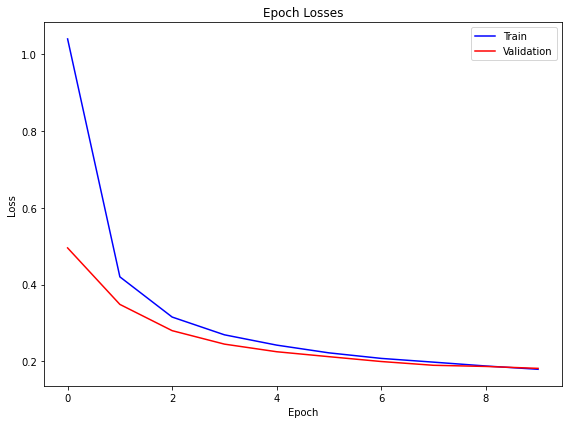

In [16]:
print('Test Acc: {:.2f}%'.format(resnet_acc))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(resnet_train_losses, c="b", label="Train")
axes.plot(resnet_val_losses, c="r", label="Validation")
axes.set_title("Epoch Losses")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.legend(loc="best")
fig.tight_layout()

Pretrained ResNet50 has performed quite well on the validation set, however even though it neither overfit nor underfit the training data, its test set score isn't as remarkable as scores obtained on the validation set.

# DenseNet-121
## Train DenseNet-121

Avoid overfitting and underfitting as much as possible. **Try to get highest validation and test accuracy (at least 65%)**

In [17]:
# You can use the same training mechanism above. Now, you will use DenseNet-121 as your model 
model = densenet121
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
criteria = nn.CrossEntropyLoss()

_, densenet_train_losses, _, densenet_val_losses = train_model(train_loader, val_loader, model, optimizer, criteria, n_epochs=10)

Train [1,    40] running loss: 1.72580
Train [1,    80] running loss: 0.92024
Train [1,   120] running loss: 0.62971
Train [Epoch 1] loss: 1.02528
Val [1,    40] running loss: 0.51679
Val [Epoch 1] loss: 0.50135
Acc: 87.86%
Train [2,    40] running loss: 0.47055
Train [2,    80] running loss: 0.42800
Train [2,   120] running loss: 0.38159
Train [Epoch 2] loss: 0.41811
Val [2,    40] running loss: 0.34977
Val [Epoch 2] loss: 0.34102
Acc: 91.9%
Train [3,    40] running loss: 0.33774
Train [3,    80] running loss: 0.32437
Train [3,   120] running loss: 0.29594
Train [Epoch 3] loss: 0.31672
Val [3,    40] running loss: 0.29651
Val [Epoch 3] loss: 0.28510
Acc: 92.44%
Train [4,    40] running loss: 0.29628
Train [4,    80] running loss: 0.27156
Train [4,   120] running loss: 0.25171
Train [Epoch 4] loss: 0.26968
Val [4,    40] running loss: 0.26438
Val [Epoch 4] loss: 0.25860
Acc: 92.57%
Train [5,    40] running loss: 0.26078
Train [5,    80] running loss: 0.22491
Train [5,   120] running lo

## Testing

In [18]:
# You can use the same testing mechanism above. Now, you will use the DenseNet model you trained above 
densenet_acc = test_model(test_loader, model)

Test Acc: 86.47%


### Plot the training and validation losses versus number of iterations or epochs for DenseNet-121 on the same plot and obtain test accuracy

Test Acc: 86.47%


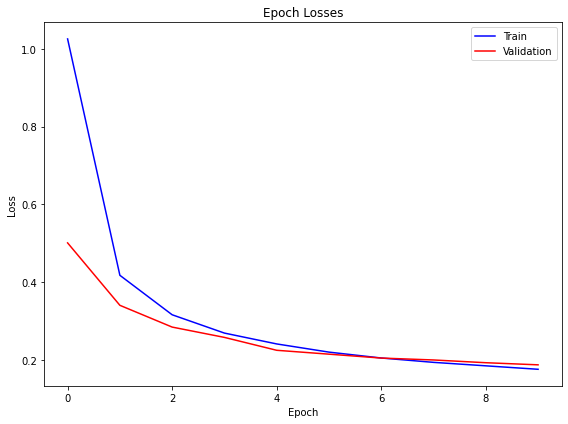

In [19]:
print('Test Acc: {:.2f}%'.format(densenet_acc))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.plot(densenet_train_losses, c="b", label="Train")
axes.plot(densenet_val_losses, c="r", label="Validation")
axes.set_title("Epoch Losses")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.legend(loc="best")
fig.tight_layout()

Pretrained DenseNet121 has performed quite well both on the validation set and the test set without any signs of over/under-fitting.

# BatchNorm Comparison

**Create two models one with batchnorm layers and one without batchnorm layers. Train them. If your YourModel() satisfies any of these conditions, you can use it for comparison.**

In [20]:
# Define your model with BatchNorm and train it. Skip this if you use YourModel() for this condition.
class BatchNormModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, dilation=3, padding=1, padding_mode="reflect")
        self.conv2 = nn.Conv2d(8, 32, 5, stride=5)
        self.conv2_bn = nn.BatchNorm2d(self.conv2.out_channels)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 5 * 5, 256)
        self.fc1_bn = nn.BatchNorm1d(self.fc1.out_features)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.fc2(x)
        return x


bn_model = BatchNormModel()
bnmodel_optimizer = optim.SGD(bn_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
_, bnmodel_train_losses, _, bnmodel_val_losses = train_model(train_loader, val_loader, bn_model, bnmodel_optimizer, criteria)

Train [1,    40] running loss: 2.05162
Train [1,    80] running loss: 1.68566
Train [1,   120] running loss: 1.50615
Train [Epoch 1] loss: 1.71291
Val [1,    40] running loss: 1.52775
Val [Epoch 1] loss: 1.47109
Acc: 50.03%
Train [2,    40] running loss: 1.36390
Train [2,    80] running loss: 1.27965
Train [2,   120] running loss: 1.24732
Train [Epoch 2] loss: 1.29131
Val [2,    40] running loss: 1.31152
Val [Epoch 2] loss: 1.28901
Acc: 55.28%
Train [3,    40] running loss: 1.17683
Train [3,    80] running loss: 1.13578
Train [3,   120] running loss: 1.08670
Train [Epoch 3] loss: 1.13581
Val [3,    40] running loss: 1.22178
Val [Epoch 3] loss: 1.17748
Acc: 58.93%
Train [4,    40] running loss: 1.06012
Train [4,    80] running loss: 1.04829
Train [4,   120] running loss: 1.03557
Train [Epoch 4] loss: 1.04534
Val [4,    40] running loss: 1.13515
Val [Epoch 4] loss: 1.11329
Acc: 60.05%
Train [5,    40] running loss: 0.97788
Train [5,    80] running loss: 0.96510
Train [5,   120] running l

In [21]:
# Define your model without BatchNorm and train it. Skip this if you use YourModel() for this condition.
your_model = YourModel()
yourmodel_optimizer = optim.SGD(your_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
_, yourmodel_train_losses, _, yourmodel_val_losses = train_model(train_loader, val_loader, your_model, yourmodel_optimizer, criteria)

Train [1,    40] running loss: 2.25978
Train [1,    80] running loss: 2.18462
Train [1,   120] running loss: 2.08885
Train [Epoch 1] loss: 2.16185
Val [1,    40] running loss: 1.99024
Val [Epoch 1] loss: 1.99546
Acc: 30.72%
Train [2,    40] running loss: 1.91384
Train [2,    80] running loss: 1.84353
Train [2,   120] running loss: 1.75649
Train [Epoch 2] loss: 1.83233
Val [2,    40] running loss: 1.78077
Val [Epoch 2] loss: 1.78390
Acc: 38.29%
Train [3,    40] running loss: 1.71948
Train [3,    80] running loss: 1.67517
Train [3,   120] running loss: 1.62753
Train [Epoch 3] loss: 1.67297
Val [3,    40] running loss: 1.66414
Val [Epoch 3] loss: 1.69317
Acc: 40.68%
Train [4,    40] running loss: 1.61881
Train [4,    80] running loss: 1.54785
Train [4,   120] running loss: 1.53445
Train [Epoch 4] loss: 1.56073
Val [4,    40] running loss: 1.58800
Val [Epoch 4] loss: 1.58905
Acc: 43.93%
Train [5,    40] running loss: 1.51517
Train [5,    80] running loss: 1.43396
Train [5,   120] running l

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies.**

Test Acc: 50.57%


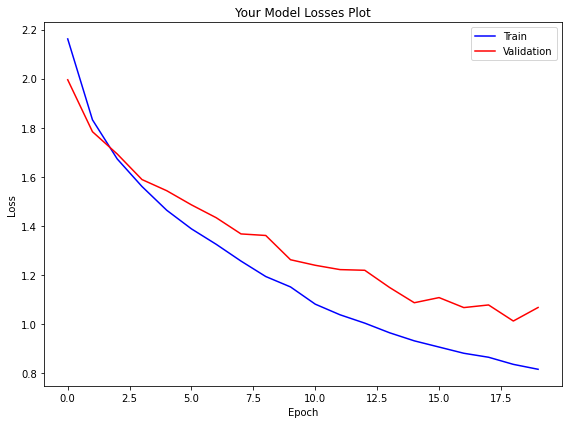

In [33]:
yourmodel_acc = test_model(test_loader, your_model)
plot_model(yourmodel_train_losses, yourmodel_val_losses, "Your Model Losses Plot")

Test Acc: 55.20%


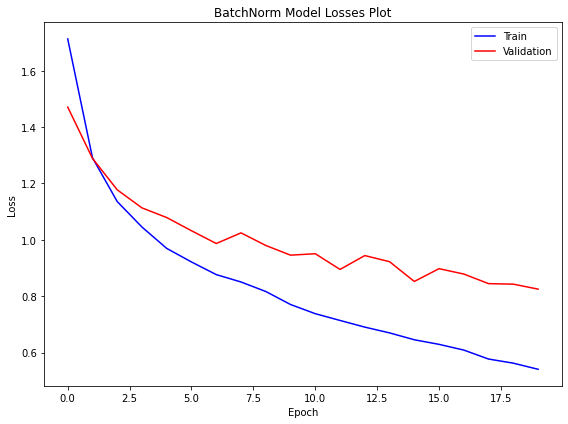

In [23]:
bnmodel_acc = test_model(test_loader, bn_model)
plot_model(bnmodel_train_losses, bnmodel_val_losses, "BatchNorm Model Losses Plot")

Batch normalization helped generalize the data better as expected and increased test accuracies. Please note that the test accuracy of YourModel() differs from the initial one because weights are randomly initialized each run and YourModel() is trained from scratch TWICE. This is intentional in order to show the results in a more compact fashion.

# Dropout Comparison

**Create two models one with dropout layers and one without dropout layers. Train them. If your YourModel() satisfies any of these conditions, you can use it for comparison.**

In [24]:
# Define your model with Dropout and train it. Skip this if you use YourModel() for this condition.
class DropoutModel(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, dilation=3, padding=1, padding_mode="reflect")
        self.conv2 = nn.Conv2d(8, 32, 5, stride=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.dropout(self.conv2(x))))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.dropout(self.fc1(x)))
        x = self.fc2(x)
        return x


dropout_model = DropoutModel()
dropoutmodel_optimizer = optim.SGD(dropout_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=regularization_rate)
_, dropoutmodel_train_losses, _, dropoutmodel_val_losses = train_model(train_loader, val_loader, dropout_model, dropoutmodel_optimizer, criteria)

Train [1,    40] running loss: 2.24052
Train [1,    80] running loss: 2.07842
Train [1,   120] running loss: 1.96942
Train [Epoch 1] loss: 2.07163
Val [1,    40] running loss: 1.94538
Val [Epoch 1] loss: 1.95117
Acc: 34.17%
Train [2,    40] running loss: 1.87063
Train [2,    80] running loss: 1.81740
Train [2,   120] running loss: 1.76271
Train [Epoch 2] loss: 1.80727
Val [2,    40] running loss: 1.82231
Val [Epoch 2] loss: 1.84148
Acc: 38.95%
Train [3,    40] running loss: 1.71118
Train [3,    80] running loss: 1.69271
Train [3,   120] running loss: 1.63866
Train [Epoch 3] loss: 1.67480
Val [3,    40] running loss: 1.76478
Val [Epoch 3] loss: 1.75759
Acc: 41.8%
Train [4,    40] running loss: 1.63454
Train [4,    80] running loss: 1.56920
Train [4,   120] running loss: 1.54539
Train [Epoch 4] loss: 1.57422
Val [4,    40] running loss: 1.68115
Val [Epoch 4] loss: 1.68452
Acc: 44.66%
Train [5,    40] running loss: 1.51729
Train [5,    80] running loss: 1.52956
Train [5,   120] running lo

In [25]:
# Define your model without Dropout and train it. Skip this if you use YourModel() for this condition.

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies.**

Test Acc: 50.57%


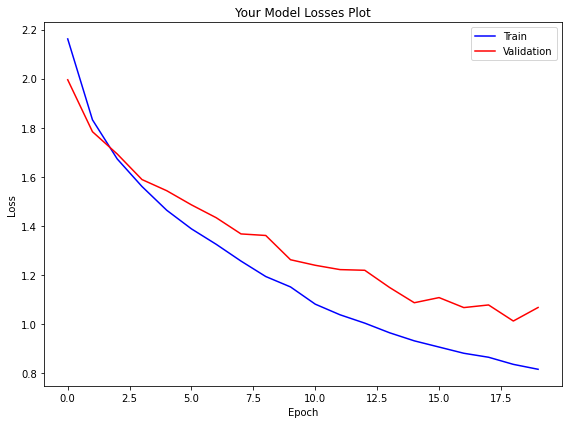

In [26]:
yourmodel_acc = test_model(test_loader, your_model)
plot_model(yourmodel_train_losses, yourmodel_val_losses, "Your Model Losses Plot")

Test Acc: 56.05%


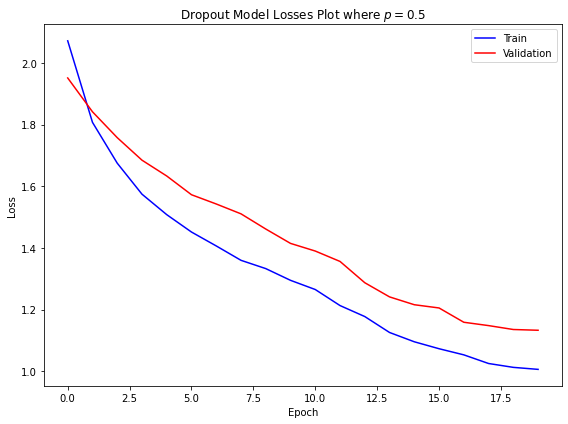

In [27]:
dropoutmodel_acc = test_model(test_loader, dropout_model)
plot_model(dropoutmodel_train_losses, dropoutmodel_val_losses, "Dropout Model Losses Plot where $p=0.5$")

Same conclusion can be made for the dropout as well. By randomly choosing which neurons to activate at each run, our model generalized to the data better and achieved higher accuracy results.

# Optimizer Comparison

**Optimize two identical models one with SGD+Momentum and one with Adam. If your training for YourModel() satisfies any of these conditions, you can use it for comparison.**

In [28]:
# Train your model with SGD+Momentum. Skip this if you use YourModel() for this condition.

In [29]:
# Train your model with Adam. Skip this if you use YourModel() for this condition.
adam_model = YourModel()
adam_optimizer = optim.Adam(adam_model.parameters(), lr=learning_rate, weight_decay=regularization_rate)
_, adam_train_losses, _, adam_val_losses = train_model(train_loader, val_loader, adam_model, adam_optimizer, criteria)

Train [1,    40] running loss: 1.92992
Train [1,    80] running loss: 1.54143
Train [1,   120] running loss: 1.34074
Train [Epoch 1] loss: 1.55730
Val [1,    40] running loss: 1.39325
Val [Epoch 1] loss: 1.40337
Acc: 51.16%
Train [2,    40] running loss: 1.17799
Train [2,    80] running loss: 1.12448
Train [2,   120] running loss: 1.07885
Train [Epoch 2] loss: 1.11447
Val [2,    40] running loss: 1.10694
Val [Epoch 2] loss: 1.14104
Acc: 60.45%
Train [3,    40] running loss: 1.01225
Train [3,    80] running loss: 0.97355
Train [3,   120] running loss: 0.96825
Train [Epoch 3] loss: 0.98041
Val [3,    40] running loss: 1.06369
Val [Epoch 3] loss: 1.10352
Acc: 62.18%
Train [4,    40] running loss: 0.87406
Train [4,    80] running loss: 0.87949
Train [4,   120] running loss: 0.91074
Train [Epoch 4] loss: 0.89162
Val [4,    40] running loss: 1.02286
Val [Epoch 4] loss: 1.03848
Acc: 64.96%
Train [5,    40] running loss: 0.79786
Train [5,    80] running loss: 0.84492
Train [5,   120] running l

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies**

Test Acc: 50.57%


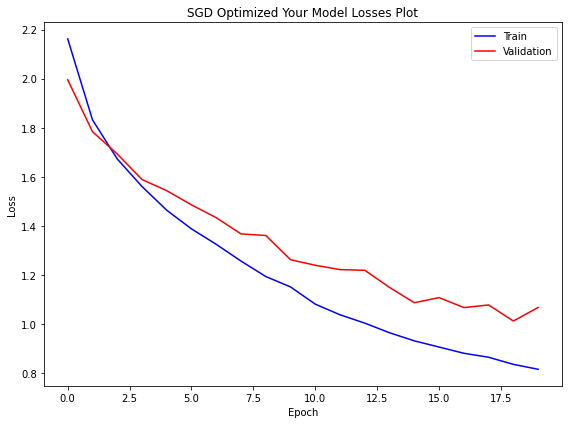

In [30]:
sgd_acc = test_model(test_loader, your_model)
plot_model(yourmodel_train_losses, yourmodel_val_losses, "SGD Optimized Your Model Losses Plot")

Test Acc: 58.83%


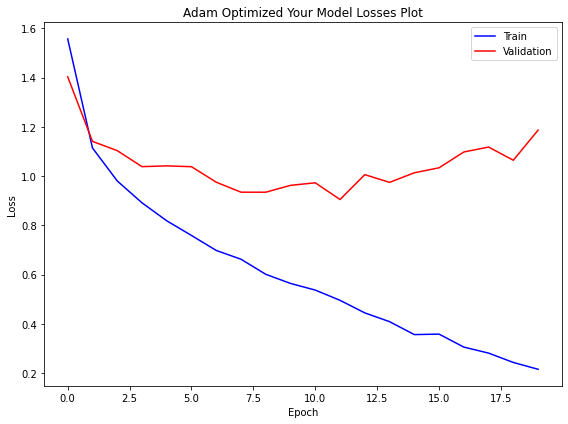

In [31]:
adam_acc = test_model(test_loader, adam_model)
plot_model(adam_train_losses, adam_val_losses, "Adam Optimized Your Model Losses Plot")

Adam optimizer has helped the model to learn and fit to the data a lot faster than SGD, by taking optimization steps resulted from computation of the decaying average of past squared gradients (RMSProp alike) and past gradients (SGD with momentum alike). Thanks to this, we can now observe within 10 to 12 epochs that our model is not sufficient enough to generalize and needs to be deeper. By increasing the number of convolutions and kernels, we can allow our model to learn more features.

#### After you have completed the training, save your best model using the following command
#### Upload your best model to Google Drive and copy your link here: [Link to Model](https://drive.google.com/file/d/1mkcXGJcRVDsCa_nkOQ2eOrhveeDB3M4E/view?usp=sharing) (https://drive.google.com/file/d/1mkcXGJcRVDsCa_nkOQ2eOrhveeDB3M4E/view?usp=sharing)

In [32]:
student_id = 150180705
model_path = os.path.join(abs_path, '{}.pth'.format(student_id))
torch.save(model.state_dict(), model_path)